<a href="https://colab.research.google.com/github/farahwadya/Car-insurance-intermediate-machine-learning-project/blob/main/Car_insurance_prj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# upload packages

In [178]:
import pandas as pd
#split to train and test model
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn import set_config
set_config(transform_output='pandas')
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from tensorflow.keras import metrics


In [179]:
"""MULTIVARIATE PLOTTING FUNCTIONS VS. NUMERIC TARGET"""

def plot_categorical_vs_target(df, x, y='charges',figsize=(6,4),
                            fillna = True, placeholder = 'MISSING',
                            order = None):
  """Plots a combination of a seaborn barplot of means combined with
  a seaborn stripplot to show the spread of the data.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Make a copy of the dataframe and fillna
  temp_df = df.copy()
  # fillna with placeholder
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)

  # or drop nulls prevent unwanted 'nan' group in stripplot
  else:
    temp_df = temp_df.dropna(subset=[x])
  # Create the figure and subplots
  fig, ax = plt.subplots(figsize=figsize)

    # Barplot
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,
              linewidth=1, edgecolor='black', errorbar=None)

  # Boxplot
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax,
                order=order, hue_order=order, legend=False,
                edgecolor='white', linewidth=0.5,
                size=3,zorder=0)
  # Rotate xlabels
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

  # Add a title
  ax.set_title(f"{x} vs. {y}", fontweight='bold')
  fig.tight_layout()
  return fig, ax


def plot_numeric_vs_target(df, x, y='rating',
                           figsize=(6,4)):
  """Plots a seaborn regplot with Pearson's correlation (r) added
  to the title.
  Source:{PASTE IN FINAL LESSON LINK}
  """
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]

  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidths':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws)

  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})", fontweight='bold')

  # Make sure the plot is shown before the print statement
  plt.show()

  return fig, ax

In [180]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
def classification_metrics(y_true, y_pred, label='',
                           output_dict=False, figsize=(8,4),
                           normalize='true', cmap='Blues',
                           colorbar=False):
  # Get the classification report
  report = classification_report(y_true, y_pred)
  ## Print header and report
  header = "-"*70
  print(header, f" Classification Metrics: {label}", header, sep='\n')
  print(report)
  ## CONFUSION MATRICES SUBPLOTS
  fig, axes = plt.subplots(ncols=2, figsize=figsize)
  # create a confusion matrix  of raw counts
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=None, cmap='gist_gray', colorbar=colorbar,
                ax = axes[0],);
  axes[0].set_title("Raw Counts")
  # create a confusion matrix with the test data
  ConfusionMatrixDisplay.from_predictions(y_true, y_pred,
                normalize=normalize, cmap=cmap, colorbar=colorbar,
                ax = axes[1]);
  axes[1].set_title("Normalized Confusion Matrix")
  # Adjust layout and show figure
  fig.tight_layout()
  plt.show()
  # Return dictionary of classification_report
  if output_dict==True:
    report_dict = classification_report(y_true, y_pred, output_dict=True)
    return report_dict
def evaluate_classification(model, X_train, y_train, X_test, y_test,
                         figsize=(6,4), normalize='true', output_dict = False,
                            cmap_train='Blues', cmap_test="Reds",colorbar=False):
  # Get predictions for training data
  y_train_pred = model.predict(X_train)
  # Call the helper function to obtain regression metrics for training data
  results_train = classification_metrics(y_train, y_train_pred, #verbose = verbose,
                                     output_dict=True, figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_train,
                                     label='Training Data')
  print()
  # Get predictions for test data
  y_test_pred = model.predict(X_test)
  # Call the helper function to obtain regression metrics for test data
  results_test = classification_metrics(y_test, y_test_pred, #verbose = verbose,
                                  output_dict=True,figsize=figsize,
                                         colorbar=colorbar, cmap=cmap_test,
                                    label='Test Data' )
  if output_dict == True:
    # Store results in a dataframe if ouput_frame is True
    results_dict = {'train':results_train,
                    'test': results_test}
    return results_dict

In [181]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

# Dataset

In [182]:
fpath='/content/drive/MyDrive/AXSOSACADEMY/05-IntermediateML/Car_Insurance_Claim.csv'
df=pd.read_csv(fpath)
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,65+,female,majority,0-9y,high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,16-25,male,majority,0-9y,none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,16-25,female,majority,0-9y,high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,16-25,male,majority,0-9y,university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,26-39,male,majority,10-19y,none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [183]:
df.describe()

,ID,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
count,10000.000000,9018.000000,10000.000000,10000.000000,10000.000000,10000.000000,9043.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,500521.906800,0.515813,0.697000,0.498200,0.688800,19864.548400,11697.003207,1.482900,0.23920,1.056300,0.313300
std,290030.768758,0.137688,0.459578,0.500022,0.463008,18915.613855,2818.434528,2.241966,0.55499,1.652454,0.463858
min,101.000000,0.053358,0.000000,0.000000,0.000000,10238.000000,2000.000000,0.000000,0.00000,0.000000,0.000000
25%,249638.500000,0.417191,0.000000,0.000000,0.000000,10238.000000,10000.000000,0.000000,0.00000,0.000000,0.000000
50%,501777.000000,0.525033,1.000000,0.000000,1.000000,10238.000000,12000.000000,0.000000,0.00000,0.000000,0.000000
75%,753974.500000,0.618312,1.000000,1.000000,1.000000,32765.000000,14000.000000,2.000000,0.00000,2.000000,1.000000
max,999976.000000,0.960819,1.000000,1.000000,1.000000,92101.000000,22000.000000,22.000000,6.00000,15.000000,1.000000


In [184]:
df.shape

(10000, 19)

In [185]:
df['OUTCOME'].unique()

array([0., 1.])

# Data cleaning

## Data type and inconsistent

In [186]:
print(df.dtypes)

ID                       int64
AGE                     object
GENDER                  object
RACE                    object
DRIVING_EXPERIENCE      object
EDUCATION               object
INCOME                  object
CREDIT_SCORE           float64
VEHICLE_OWNERSHIP      float64
VEHICLE_YEAR            object
MARRIED                float64
CHILDREN               float64
POSTAL_CODE              int64
ANNUAL_MILEAGE         float64
VEHICLE_TYPE            object
SPEEDING_VIOLATIONS      int64
DUIS                     int64
PAST_ACCIDENTS           int64
OUTCOME                float64
dtype: object


### Age

In [187]:
df['AGE'].unique()

array(['65+', '16-25', '26-39', '40-64'], dtype=object)

In [188]:
age_map = {
    '16-25': 'Young',
    '26-39': 'Adult',
    '40-64': 'Middle-aged',
    '65+': 'Old'
}
df['AGE'] = df['AGE'].map(age_map)

In [189]:
df['AGE'].unique()

array(['Old', 'Young', 'Adult', 'Middle-aged'], dtype=object)

In [190]:
df['GENDER'].unique()

array(['female', 'male'], dtype=object)

In [191]:
df['RACE'].unique()

array(['majority', 'minority'], dtype=object)

In [192]:
df['DRIVING_EXPERIENCE'].unique()

array(['0-9y', '10-19y', '20-29y', '30y+'], dtype=object)

In [193]:
df['EDUCATION'].unique()

array(['high school', 'none', 'university'], dtype=object)

In [194]:
df['INCOME'].unique()

array(['upper class', 'poverty', 'working class', 'middle class'],
      dtype=object)

In [195]:
df['VEHICLE_YEAR'].unique()

array(['after 2015', 'before 2015'], dtype=object)

In [196]:
df['VEHICLE_TYPE'].unique()

array(['sedan', 'sports car'], dtype=object)

### Driving experience

In [197]:
experience_map = {
    '0-9y': 'Novice (0-9y)',
    '10-19y': 'Intermediate (10-19y)',
    '20-29y': 'Experienced (20-29y)',
    '30y+': 'Expert (30y+)'
}

df['DRIVING_EXPERIENCE'] = df['DRIVING_EXPERIENCE'].map(experience_map)

## null values

In [198]:
df.isna().sum()

,0
ID,0
AGE,0
GENDER,0
RACE,0
DRIVING_EXPERIENCE,0
EDUCATION,0
INCOME,0
CREDIT_SCORE,982
VEHICLE_OWNERSHIP,0
VEHICLE_YEAR,0


## duplicates

In [199]:
df.duplicated().sum()

np.int64(0)

# Exploration

In [200]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Old,female,majority,Novice (0-9y),high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Novice (0-9y),none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Novice (0-9y),high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Novice (0-9y),university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Adult,male,majority,Intermediate (10-19y),none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


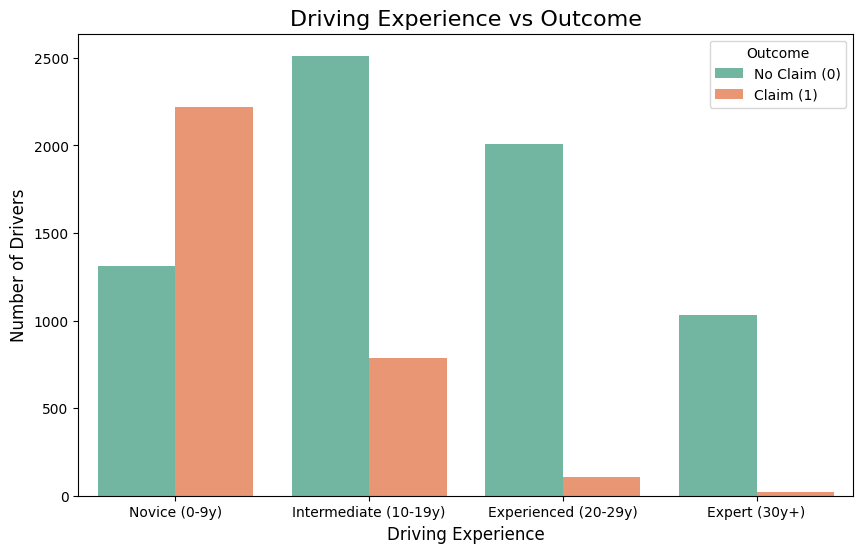

In [201]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(10,6))

# Plot countplot: Driving Experience vs Outcome, colored by OUTCOME
sns.countplot(
    data=df,
    x='DRIVING_EXPERIENCE',
    hue='OUTCOME',
    palette='Set2',
    dodge=True
)

# Add title and axis labels
plt.title('Driving Experience vs Outcome', fontsize=16)
plt.xlabel('Driving Experience', fontsize=12)
plt.ylabel('Number of Drivers', fontsize=12)

# Customize legend
plt.legend(title='Outcome', labels=['No Claim (0)', 'Claim (1)'])

# Show plot
plt.show()


This visualization shows that driving experience affects the insurance outcome. Novice drivers (0-9y) have the highest number of claims, while more experienced drivers (20-29y and 30y+) tend to have fewer claims. This indicates a negative correlation between driving experience and the likelihood of filing a claim.

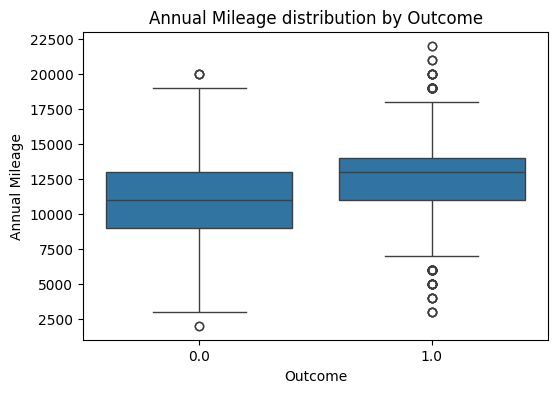

In [202]:
plt.figure(figsize=(6,4))
sns.boxplot(x='OUTCOME', y='ANNUAL_MILEAGE', data=df)
plt.xlabel('Outcome')
plt.ylabel('Annual Mileage')
plt.title('Annual Mileage distribution by Outcome')
plt.show()


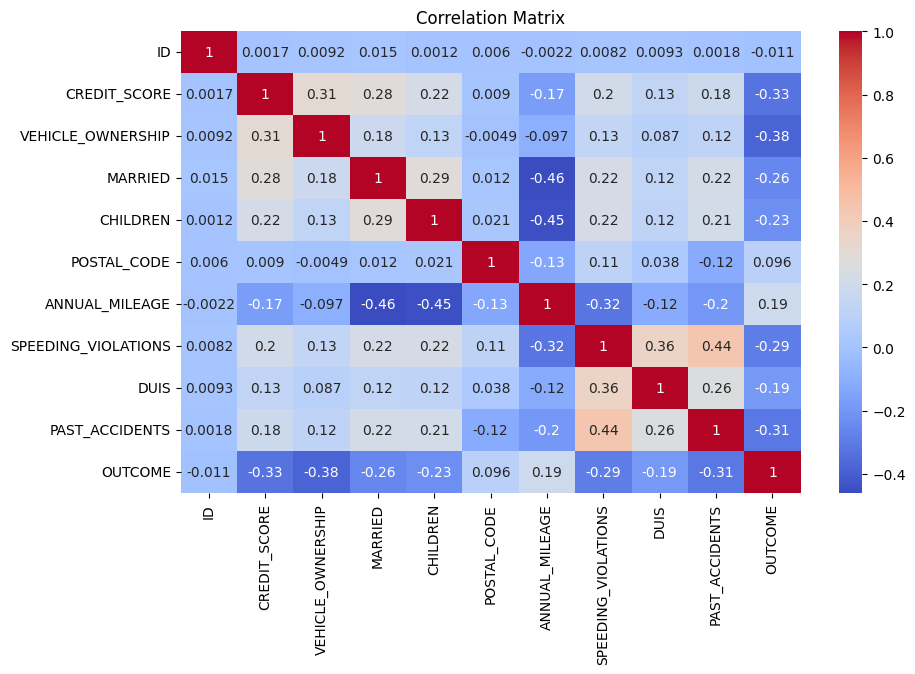

In [203]:
plt.figure(figsize=(10,6))
sns.heatmap(df.corr(numeric_only=True), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


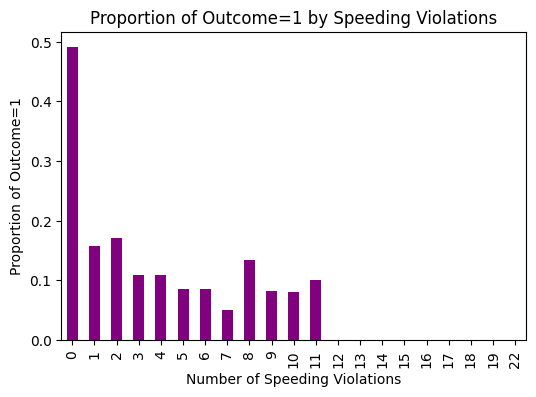

In [204]:
import matplotlib.pyplot as plt
import pandas as pd

# حساب النسبة لكل عدد مخالفات
summary = df.groupby('SPEEDING_VIOLATIONS')['OUTCOME'].mean()

plt.figure(figsize=(6,4))
summary.plot(kind='bar', color='purple')
plt.xlabel('Number of Speeding Violations')
plt.ylabel('Proportion of Outcome=1')
plt.title('Proportion of Outcome=1 by Speeding Violations')
plt.show()



Zero speeding violation shows the highest average outcome(1) which is an unusal thing while >7 violation speed tend to show lower average outcome

In [205]:
# حساب العدد لكل فئة عمرية لكل Outcome
age_counts = df.groupby(['AGE', 'OUTCOME']).size().unstack(fill_value=0)
print(age_counts)


OUTCOME       0.0   1.0
AGE                    
Adult        2031  1032
Middle-aged  2474   457
Old          1794   196
Young         568  1448


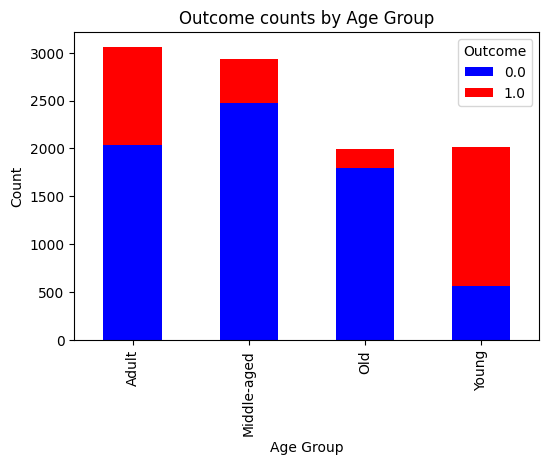

In [206]:
age_counts.plot(kind='bar', stacked=True, color=['blue','red'], figsize=(6,4))
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.title('Outcome counts by Age Group')
plt.legend(title='Outcome')
plt.show()


- Young people shows the highest counts of outcome=1, while middle_aged (40-64)shows the least number of caliming outcome(1)

In [207]:
import seaborn as sns
import matplotlib.pyplot as plt
def plot_numeric_vs_target(df, x, y='SalePrice', figsize=(6,4), **kwargs): # kwargs for sns.regplot
  # Calculate the correlation
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  # Plot the data
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','lw':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs) # Included the new argument within the sns.regplot function
  ## Add the title with the correlation
  ax.set_title(f"{x} vs. {y} (r = {r})")
  # Make sure the plot is shown before the print statement
  plt.show()
  return fig, ax

In [208]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Old,female,majority,Novice (0-9y),high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Novice (0-9y),none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Novice (0-9y),high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Novice (0-9y),university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Adult,male,majority,Intermediate (10-19y),none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [209]:
df['POSTAL_CODE'].unique()

array([10238, 32765, 92101, 21217])

# preprocessing

## train test split

In [210]:
#define target feature
y = df['OUTCOME']
X = df.drop(columns=['ID','OUTCOME','POSTAL_CODE'])
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

## ord cols

In [211]:
df.head()

,ID,AGE,GENDER,RACE,DRIVING_EXPERIENCE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,VEHICLE_YEAR,MARRIED,CHILDREN,POSTAL_CODE,ANNUAL_MILEAGE,VEHICLE_TYPE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS,OUTCOME
0,569520,Old,female,majority,Novice (0-9y),high school,upper class,0.629027,1.0,after 2015,0.0,1.0,10238,12000.0,sedan,0,0,0,0.0
1,750365,Young,male,majority,Novice (0-9y),none,poverty,0.357757,0.0,before 2015,0.0,0.0,10238,16000.0,sedan,0,0,0,1.0
2,199901,Young,female,majority,Novice (0-9y),high school,working class,0.493146,1.0,before 2015,0.0,0.0,10238,11000.0,sedan,0,0,0,0.0
3,478866,Young,male,majority,Novice (0-9y),university,working class,0.206013,1.0,before 2015,0.0,1.0,32765,11000.0,sedan,0,0,0,0.0
4,731664,Adult,male,majority,Intermediate (10-19y),none,working class,0.388366,1.0,before 2015,0.0,0.0,32765,12000.0,sedan,2,0,1,1.0


In [212]:
ord_cols = ["DRIVING_EXPERIENCE",'AGE', 'EDUCATION', 'INCOME' ]
ord1=['Novice (0-9y)', 'Intermediate (10-19y)', 'Experienced (20-29y)',
       'Expert (30y+)']
ord2=['Young', 'Adult', 'Middle-aged', 'Old']
ord3=['none','high school',  'university']
ord4=['poverty','working class', 'middle class','upper class'  ]
ordinal=OrdinalEncoder(categories=[ord1,ord2,ord3,ord4])
scaler=StandardScaler()
impute_missing=SimpleImputer(strategy='most_frequent')
ord_pipe=make_pipeline(impute_missing,ordinal,scaler)
ord_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                ('ordinalencoder',
                 OrdinalEncoder(categories=[['Novice (0-9y)',
                                             'Intermediate (10-19y)',
                                             'Experienced (20-29y)',
                                             'Expert (30y+)'],
                                            ['Young', 'Adult', 'Middle-aged',
                                             'Old'],
                                            ['none', 'high school',
                                             'university'],
                                            ['poverty', 'working class',
                                             'middle class', 'upper class']])),
                ('standardscaler', StandardScaler())])

In [213]:
ord_tuple=('ordinal',ord_pipe,ord_cols)

In [214]:
df['INCOME'].unique()

array(['upper class', 'poverty', 'working class', 'middle class'],
      dtype=object)

## cat cols

In [215]:
cat_cols=X_train.select_dtypes(include='object').drop(columns=ord_cols).columns
cat_cols

Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object')

In [216]:
impute_cat=SimpleImputer(strategy='constant',fill_value='MISSING')
one_hot=OneHotEncoder(handle_unknown='ignore',drop='first',sparse_output=False)
cat_pipe=make_pipeline(impute_cat,one_hot)
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='MISSING', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(drop='first', handle_unknown='ignore',
                               sparse_output=False))])

In [217]:
cat_tuple=('categorical',cat_pipe,cat_cols)

## num_cols

In [218]:
num_cols=X_train.select_dtypes(include='number').columns
num_cols

Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object')

In [219]:
impute_num=SimpleImputer(strategy='median') # imputing with median as there are some outliers, so the mean would be affected by
num_pipe=make_pipeline(impute_num,scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [220]:
df['OUTCOME'].value_counts(normalize=True)

,proportion
OUTCOME,
0.0,0.6867
1.0,0.3133


In [221]:
num_tuple=('numeric',num_pipe,num_cols)

## col transformer

In [222]:
preprocessor = ColumnTransformer(
    transformers=[cat_tuple,ord_tuple,num_tuple],remainder='passthrough',
                                    verbose_feature_names_out=False)
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('categorical',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='MISSING',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['GENDER', 'RACE', 'VEHICLE_YEAR', 'VEHICLE_TYPE'], dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=...
                                                  StandardScaler())]),
                                 ['DRIVING_EXPERIENCE', 'AGE', 'EDUCATION',
                                  'INCOME']),
                                ('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['CREDIT_SCORE', 'VEHICLE_OWNERSHIP', 'MARRIED', 'CHILDREN',
       'ANNUAL_MILEAGE', 'SPEEDING_VIOLATIONS', 'DUIS', 'PAST_ACCIDENTS'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [223]:
X_train_tf=preprocessor.fit_transform(X_train)
X_train_tf.head()

,GENDER_male,RACE_minority,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sports car,DRIVING_EXPERIENCE,AGE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
9254,0.0,0.0,0.0,0.0,1.933727,1.466105,-0.279326,0.959008,0.225158,0.661480,0.997004,0.677143,-1.390556,1.111686,-0.433018,2.940435
1561,1.0,0.0,1.0,0.0,-1.078309,-0.478815,-1.633635,-1.655576,-1.184005,-1.511761,0.997004,0.677143,-1.017165,-0.661338,-0.433018,-0.642457
1670,0.0,1.0,1.0,0.0,-1.078309,-0.478815,1.074983,0.087480,0.151632,0.661480,0.997004,-1.476792,0.103009,-0.661338,-0.433018,-0.642457
6087,0.0,0.0,0.0,0.0,-0.074297,0.493645,-0.279326,0.959008,0.740542,0.661480,0.997004,-1.476792,-1.017165,0.668430,-0.433018,-0.642457
6669,1.0,0.0,1.0,0.0,-1.078309,0.493645,1.074983,0.087480,-0.321099,0.661480,-1.003005,-1.476792,0.476401,-0.661338,-0.433018,-0.642457


In [224]:
X_test_tf=preprocessor.transform(X_test)
X_test_tf.head()

,GENDER_male,RACE_minority,VEHICLE_YEAR_before 2015,VEHICLE_TYPE_sports car,DRIVING_EXPERIENCE,AGE,EDUCATION,INCOME,CREDIT_SCORE,VEHICLE_OWNERSHIP,MARRIED,CHILDREN,ANNUAL_MILEAGE,SPEEDING_VIOLATIONS,DUIS,PAST_ACCIDENTS
6252,0.0,0.0,1.0,0.0,-0.074297,-0.478815,-0.279326,0.087480,0.195818,-1.511761,0.997004,0.677143,-0.270382,-0.218082,-0.433018,-0.642457
4684,0.0,0.0,1.0,0.0,0.929715,1.466105,-0.279326,0.959008,0.286927,0.661480,0.997004,-1.476792,-1.390556,0.668430,1.346202,1.746137
1731,0.0,1.0,1.0,0.0,-1.078309,-1.451275,-1.633635,-1.655576,-2.075660,-1.511761,-1.003005,-1.476792,0.476401,-0.661338,-0.433018,-0.642457
4742,1.0,0.0,1.0,0.0,-1.078309,-1.451275,-1.633635,-1.655576,0.062604,0.661480,-1.003005,-1.476792,0.849792,-0.661338,-0.433018,-0.642457
4521,0.0,0.0,0.0,1.0,0.929715,0.493645,1.074983,0.959008,1.331058,0.661480,0.997004,0.677143,-0.643773,0.225174,-0.433018,-0.642457


# modeling

In [225]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_tf, y_train)
import numpy as np
np.bincount(y_train_res)


array([5500, 5500])

## Random Forest classifier

In [226]:
rf_clf=RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_res,y_train_res)


RandomForestClassifier(random_state=42)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5500
         1.0       1.00      1.00      1.00      5500

    accuracy                           1.00     11000
   macro avg       1.00      1.00      1.00     11000
weighted avg       1.00      1.00      1.00     11000



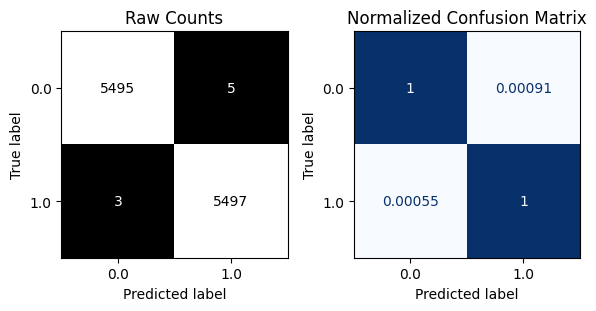


----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       0.85      0.89      0.87      1367
         1.0       0.74      0.67      0.70       633

    accuracy                           0.82      2000
   macro avg       0.80      0.78      0.79      2000
weighted avg       0.82      0.82      0.82      2000



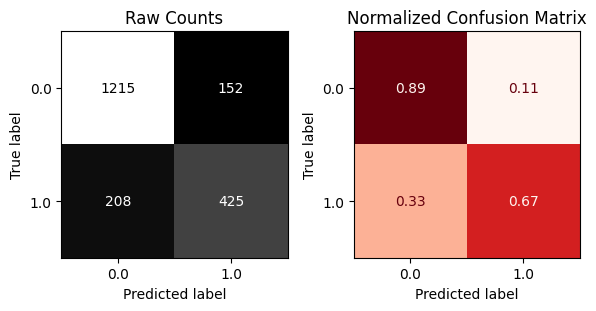

In [227]:
evaluate_classification(rf_clf, X_train_res, y_train_res, X_test_tf, y_test)

## permutation importances

In [228]:
r = permutation_importance(rf_clf, X_test_tf, y_test,n_repeats =5, random_state = 42)
r.keys()

dict_keys(['importances_mean', 'importances_std', 'importances'])

In [229]:
## can make the mean importances into a series
permutation_importances = pd.Series(r['importances_mean'],index=X_test_tf.columns,
                           name = 'permutation importance')
permutation_importances = permutation_importances.sort_values(ascending=False)
permutation_importances

,permutation importance
DRIVING_EXPERIENCE,0.0681
VEHICLE_YEAR_before 2015,0.0492
VEHICLE_OWNERSHIP,0.0381
GENDER_male,0.0125
SPEEDING_VIOLATIONS,0.0046
MARRIED,0.0039
VEHICLE_TYPE_sports car,0.0023
DUIS,0.0017
PAST_ACCIDENTS,0.0011
AGE,0.0010


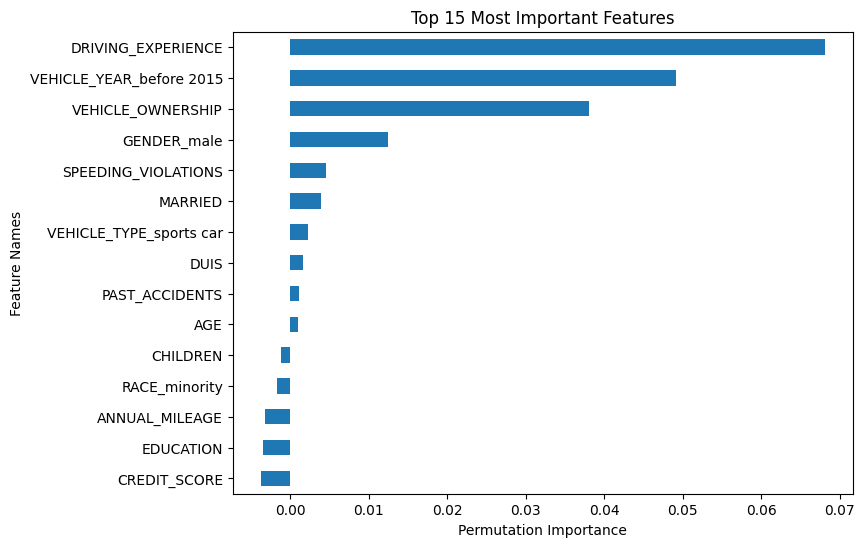

In [230]:
ax = plot_importance(permutation_importances,top_n=15)
ax.set(xlabel='Permutation Importance');

/tmp/ipython-input-257460637.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'DRIVING_EXPERIENCE vs. OUTCOME'}, xlabel='DRIVING_EXPERIENCE', ylabel='OUTCOME'>)

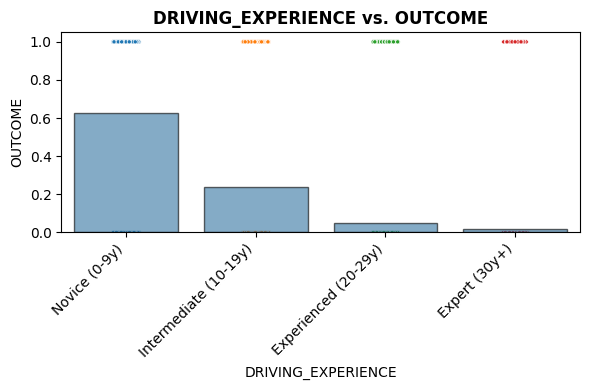

In [231]:
plot_categorical_vs_target(df, x='DRIVING_EXPERIENCE', y='OUTCOME')

The visualization reveals a critical inverse relationship between DRIVING_EXPERIENCE and the OUTCOME. The risk is highest for Novice drivers (0-9 years) at approximately 65%, and it drops dramatically as experience increases, reaching only about 1% for Expert drivers (30+ years). This indicates that experience is an extremely strong predictive feature, as novice drivers are roughly 65 times more likely to encounter the outcome than experts.

/tmp/ipython-input-257460637.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')


(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'VEHICLE_YEAR vs. OUTCOME'}, xlabel='VEHICLE_YEAR', ylabel='OUTCOME'>)

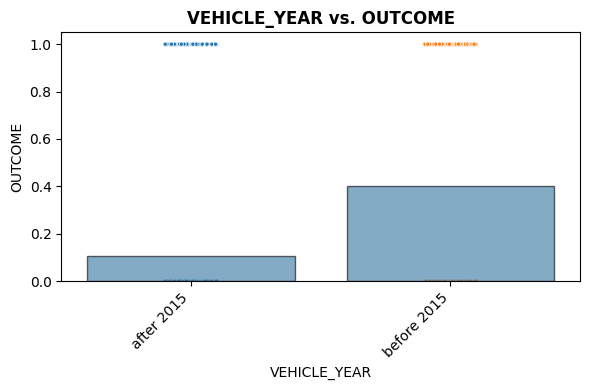

In [232]:
plot_categorical_vs_target(df, x='VEHICLE_YEAR', y='OUTCOME')
#

This plot shows that the OUTCOME likelihood is highly dependent on the vehicle's age.Older Vehicles (Before 2015): The average OUTCOME is high ($\approx 40\%$).Newer Vehicles (After 2015): The average OUTCOME is low ($\approx 10\%$).

In [233]:
df['ANNUAL_MILEAGE'].describe()

,ANNUAL_MILEAGE
count,9043.000000
mean,11697.003207
std,2818.434528
min,2000.000000
25%,10000.000000
50%,12000.000000
75%,14000.000000
max,22000.000000


# feature engineering

In [234]:
pca=PCA(n_components=.90)
pca_X_train=pca.fit_transform(X_train_res)
pca_X_test=pca.transform(X_test_tf)

In [235]:
n_components_created = pca.n_components_
print("Number of components:", n_components_created)

Number of components: 9


# Random forest 2

In [236]:
rf2=RandomForestClassifier(random_state=42)
rf2.fit(pca_X_train,y_train_res)
rf2.predict(pca_X_test)

array([1., 0., 1., ..., 0., 0., 1.])

In [ ]:
evaluate_classification(rf2, pca_X_train, y_train_res, pca_X_test, y_test)

----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      5500
         1.0       1.00      1.00      1.00      5500

    accuracy                           1.00     11000
   macro avg       1.00      1.00      1.00     11000
weighted avg       1.00      1.00      1.00     11000



In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# عد النتائج لكل postal code
sns.countplot(data=df, x='POSTAL_CODE', hue='OUTCOME')
plt.title('Distribution of OUTCOME per POSTAL_CODE')
plt.xlabel('Postal Code')
plt.ylabel('Count')
plt.show()


# feature selection (Filter method - variance)

In [ ]:
selector=VarianceThreshold(threshold=0.05)
selector.fit(X_train_res)


In [ ]:
keep_ft=selector.get_support()
keep_ft

In [ ]:
keep_ft.sum()

In [ ]:
X_train_var=X_train_res.loc[:,keep_ft]
X_test_var=X_test_tf.loc[:,keep_ft]

# Random forest model 3

In [ ]:
rf3=RandomForestClassifier(random_state=42)
rf3.fit(X_train_var,y_train_res)

In [ ]:
evaluate_classification(rf3, X_train_var, y_train_res, X_test_var, y_test)

In [ ]:
r2= permutation_importance(rf3, X_test_var, y_test,n_repeats =5, random_state = 42)
r.keys()

In [ ]:
perm_imp=pd.Series(r2['importances_mean'],index=X_test_var.columns,name='permutation importance')
perm_imp=perm_imp.sort_values(ascending=False)
perm_imp

In [ ]:
ax = plot_importance(permutation_importances,top_n=15)
ax.set(xlabel='Permutation Importance');

## kmeans model

In [ ]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
kmeans.fit(X_train_res)  # التدريب على X_train فقط


In [ ]:
# Cluster labels كfeature جديد
X_train_res['cluster'] = kmeans.labels_
X_test_tf['cluster'] = kmeans.predict(X_test_tf)


In [ ]:
rf_clf.fit(X_train_res, y_train_res)
evaluate_classification(rf_clf, X_train_res ,y_train_res, X_test_tf, y_test)


In [ ]:
r3= permutation_importance(rf_clf, X_test_tf, y_test,n_repeats =5, random_state = 42)
r.keys()

In [ ]:
perm_imp=pd.Series(r2['importances_mean'],index=X_test_var.columns,name='permutation importance')
perm_imp=perm_imp.sort_values(ascending=False)
perm_imp

In [ ]:
ax = plot_importance(permutation_importances,top_n=15)
ax.set(xlabel='Permutation Importance');

No new top features appeared, this maybe bacause of the feature selection tequnique that i used (filter by varience) the result shows that only one feature was deleted

# Deep learning neural network

In [ ]:
input_shape=X_train_res.shape[1]
input_shape

In [177]:
def build_model(hp):

    model = Sequential()

    # Input Layer
    model.add(Input(shape=(input_shape,)))

    # Hidden layers (KerasTuner decides how many)
    for i in range(hp.Int('num_layers', min_value=1, max_value=3)):
        model.add(Dense(
            units=hp.Int(f'units_{i}', min_value=2, max_value=16, step=2),
            activation='relu'
        ))
        model.add(Dropout(
            hp.Float(f'dropout_{i}', min_value=0.0, max_value=0.5, step=0.1)
        ))

    # Output layer for REGRESSION
    model.add(Dense(1, activation='sigmoid'))

    # Compile
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'nadam', 'rmsprop']),
        loss='mse',
        metrics=[
 'mae', 'mse'
        ]
    )

    return model
# Make a folder to store results of hyperparameter tuning
import os
folder = 'KerasTuner/'
os.makedirs(folder, exist_ok=True)

In [ ]:
model.add(Input(shape=(input_shape,)))
model.add(Dense(16, # How many neurons you have in your first hidden layer
                 activation = 'relu')) # What is the shape of your input

In [ ]:
model.add(Dense(1,activation = 'sigmoid'))


In [ ]:
    # Compile Model
    model.compile(loss = 'bce', optimizer = 'adam',
             metrics=['accuracy', metrics.Precision(), metrics.Recall()])


In [ ]:
# Get model summary
model.summary()

In [ ]:
early_stopping = EarlyStopping(patience = 5)

In [ ]:
history = model.fit(X_train_res, y_train_res,
                    validation_data = (X_test_tf, y_test),
                    epochs=50,callbacks = [early_stopping])